# ***Importing libs***

In [54]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import  OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge ,Lasso
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor



# from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) # to avoid deprecation warnings


import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

# ***First rows of the data***

In [55]:
df=pd.read_csv("/content/Walmart_Store_sales.csv")
print("Display of dataset: ")
display(df.head(3))
print()

Display of dataset: 


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,18-02-2011,1572117.54,NaN,59.61,3.045,214.777523,6.858
1,13.0,25-03-2011,1807545.43,0.0,42.38,3.435,128.616064,7.470
2,17.0,27-07-2012,NaN,0.0,NaN,NaN,130.719581,5.936


# ***Basic stats***

In [56]:
print("Number of rows : {}".format(df.shape[0]))
print()
print("Basics statistics: ")
data_desc = df.describe(include='all')
display(data_desc)
print()

Number of rows : 150

Basics statistics: 


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,150.000000,132,1.360000e+02,138.000000,132.000000,136.000000,138.000000,135.000000
unique,NaN,85,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,19-10-2012,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN
mean,9.866667,NaN,1.249536e+06,0.079710,61.398106,3.320853,179.898509,7.598430
std,6.231191,NaN,6.474630e+05,0.271831,18.378901,0.478149,40.274956,1.577173
min,1.000000,NaN,2.689290e+05,0.000000,18.790000,2.514000,126.111903,5.143000
25%,4.000000,NaN,6.050757e+05,0.000000,45.587500,2.852250,131.970831,6.597500
50%,9.000000,NaN,1.261424e+06,0.000000,62.985000,3.451000,197.908893,7.470000
75%,15.750000,NaN,1.806386e+06,0.000000,76.345000,3.706250,214.934616,8.150000


# ***Missing values***

In [57]:
df.isnull().any().value_counts()

True     7
False    1
dtype: int64

In [58]:
print("Percentage of missing values: ")
display(100*df.isnull().sum()/df.shape[0])

Percentage of missing values: 


Store            0.000000
Date            12.000000
Weekly_Sales     9.333333
Holiday_Flag     8.000000
Temperature     12.000000
Fuel_Price       9.333333
CPI              8.000000
Unemployment    10.000000
dtype: float64

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         150 non-null    float64
 1   Date          132 non-null    object 
 2   Weekly_Sales  136 non-null    float64
 3   Holiday_Flag  138 non-null    float64
 4   Temperature   132 non-null    float64
 5   Fuel_Price    136 non-null    float64
 6   CPI           138 non-null    float64
 7   Unemployment  135 non-null    float64
dtypes: float64(7), object(1)
memory usage: 9.5+ KB


# ***we  work on data without column Data in the first part ***

In [60]:
#drop flad date col
print("drop in progress...")
df0=df.drop(['Date'],axis=1)
df0.columns

drop in progress...


Index(['Store', 'Weekly_Sales', 'Holiday_Flag', 'Temperature', 'Fuel_Price',
       'CPI', 'Unemployment'],
      dtype='object')

In [61]:
print('Dropping outliers in weekly sales...')
to_keep = df0['Weekly_Sales'].isnull()!=True # We want keeping positives values or missings
df0 = df0.loc[to_keep,:] 
print('Done. Number of lines remaining : ', df0.shape[0])
print()


Dropping outliers in weekly sales...
Done. Number of lines remaining :  136



## ***Separate target variable Y from features X***

In [62]:
# Separate target variable Y from features X
print("Separating labels from features...")
target_variable = 'Weekly_Sales'

X = df0.drop(target_variable, axis = 1)
Y = df0.loc[:,target_variable]

print("...Done.")
print()

print('Y : ')
print(Y.head(2))
print()
print('X :')
print(X.head(2))

Separating labels from features...
...Done.

Y : 
0    1572117.54
1    1807545.43
Name: Weekly_Sales, dtype: float64

X :
   Store  Holiday_Flag  Temperature  Fuel_Price         CPI  Unemployment
0    6.0           NaN        59.61       3.045  214.777523         6.858
1   13.0           0.0        42.38       3.435  128.616064         7.470


## ***Divide dataset Train set & Test set***

In [63]:
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=43)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



# ***pipeline for numeric features and categorical features***

In [64]:
# Create pipeline for numeric features
numeric_features = ["Fuel_Price","Unemployment","Temperature","CPI"] # Names of numeric columns in X_train/X_test
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median',missing_values=np.nan)), # missing values will be replaced by columns' median
    ('scaler', StandardScaler())
])
# Create pipeline for categorical features
categorical_features = ['Store', 'Holiday_Flag'] # Names of categorical columns in X_train/X_test
categorical_transformer = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # missing values will be replaced by most frequent value
    ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
    ])

In [65]:
# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [66]:
# Preprocessings on train set
print("Performing preprocessings on train set...")
print(X_train.head(2))
X_train = preprocessor.fit_transform(X_train)
print('...Done.')
print(X_train[0:2]) 
print()
# Preprocessings on test set
print("Performing preprocessings on test set...")
print(X_test.head(2)) 
X_test = preprocessor.transform(X_test) # Don't fit again 
print(X_test[0:2,:]) 
print()

Performing preprocessings on train set...
    Store  Holiday_Flag  Temperature  Fuel_Price         CPI  Unemployment
48    1.0           NaN        91.65       3.684  215.544618         7.962
85    2.0           0.0        44.69       2.976  211.064888         8.028
...Done.
  (0, 0)	0.873325821332278
  (0, 1)	0.30010836673036834
  (0, 2)	1.7897254402863787
  (0, 3)	0.9056666165005199
  (1, 0)	-0.6851596529571025
  (1, 1)	0.3474467109746308
  (1, 2)	-0.8595636262198436
  (1, 3)	0.7907781173095498
  (1, 4)	1.0

Performing preprocessings on test set...
     Store  Holiday_Flag  Temperature  Fuel_Price         CPI  Unemployment
94    14.0           0.0        78.47       3.760  186.139981         8.625
137   10.0           0.0        88.44       3.112  126.128355         9.199
  (0, 0)	1.0406208722446966
  (0, 1)	0.7756435520932058
  (0, 2)	1.0461643266460035
  (0, 3)	0.15154645466599598
  (0, 16)	1.0
  (1, 0)	-0.3857895618506684
  (1, 1)	1.1873436974902936
  (1, 2)	1.6086305104847392
  (

# ***Training lineair Regression : model0***

In [67]:
# Train model
print("Train model...")
model0 = LinearRegression()
model0.fit(X_train, Y_train)
print("...Done.")

Train model...
...Done.


In [68]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = model0.predict(X_train)
print("...Done.")
print(Y_train_pred[0:2])
print()
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = model0.predict(X_test)
print("...Done.")
print(Y_test_pred[0:2])
print()

Predictions on training set...
...Done.
[1455655.02606006 1963332.29865616]

Predictions on test set...
...Done.
[1998993.02071295 1781857.88711224]



# ***R² for model0 lineair regression***

In [69]:
# Print R^2 scores
print("R2 score on training set : ", r2_score(Y_train, Y_train_pred))
print("R2 score on test set : ", r2_score(Y_test, Y_test_pred))

R2 score on training set :  0.960258885825174
R2 score on test set :  0.954555915092416


# ***Testing overfitting with cross val***

In [70]:
# cross validation with 5 K-fold 
scores = cross_val_score(model0, X_train, Y_train, cv = 5)
print(f'Scores obtained during the cross validation: {scores}')
print(f'The average of cross_val scores is {scores.mean()}')
print(f"The standard deviation on cross_val scores is {scores.std()}")

Scores obtained during the cross validation: [0.89758965 0.96613547 0.94134375 0.91397384 0.84686567]
The average of cross_val scores is 0.9131816776770993
The standard deviation on cross_val scores is 0.04059250795139309


# ***score.xval= moyenne des scores sur les cvs***
# ***if score.xval(train)-score(test) si < std  no overfit***

In [71]:
#score in test has to be in [score(val)-std,score(val)+std]
r2_score(Y_test, Y_test_pred) in [scores.mean()-scores.std(),scores.mean()+scores.std()]

False

# ***small overfiting***

# ***Let's try with Ridge & Lasso with default params in the second part when we include column date we will use grid search***

# ***Ridge***

In [72]:
ridge0 = Ridge() # Ridge(alpha=100000) ect by default equal 1
print(ridge0)
ridge0.fit(X_train, Y_train)
# Print R^2 scores
print("R2 score on training set : ", ridge0.score(X_train, Y_train))
print("R2 score on test set : ", ridge0.score(X_test, Y_test))

Ridge()
R2 score on training set :  0.9241038033228304
R2 score on test set :  0.923931169355264


# ***Lasso***

In [73]:
lasso0 = Lasso()
print(lasso0)
lasso0.fit(X_train, Y_train)
# Print R^2 scores
print("R2 score on training set : ", lasso0.score(X_train, Y_train))
print("R2 score on test set : ", lasso0.score(X_test, Y_test))

Lasso()
R2 score on training set :  0.9602588816664057
R2 score on test set :  0.9545670789337628


In [74]:
table=pd.DataFrame()
table['model name']=['model0','ridge0','lasso0']
table['train score']=[r2_score(Y_train, Y_train_pred),ridge0.score(X_train, Y_train),lasso0.score(X_train, Y_train)]
table['test score']=[r2_score(Y_test, Y_test_pred),ridge0.score(X_test, Y_test),lasso0.score(X_test, Y_test)]
table

,model name,train score,test score
0,model0,0.960259,0.954556
1,ridge0,0.924104,0.923931
2,lasso0,0.960259,0.954567


# **lets work on DATE column**

In [81]:
n,m=df.shape
year=[]
day=[]
month=[]
for i in range(n):
  if df['Date'].isnull()[i]==False:
    h=df['Date'][i]
    year.append(h.split("-")[0])
    month.append(h.split("-")[1])
    day.append(h.split("-")[2])
  else:
    year.append(np.nan)
    month.append(np.nan)
    day.append(np.nan)
df['year']=year
df['month']=month
df['day']=day
df.head()    

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year,month,day
0,6.0,18-02-2011,1572117.54,NaN,59.61,3.045,214.777523,6.858,18,02,2011
1,13.0,25-03-2011,1807545.43,0.0,42.38,3.435,128.616064,7.470,25,03,2011
2,17.0,27-07-2012,NaN,0.0,NaN,NaN,130.719581,5.936,27,07,2012
3,11.0,NaN,1244390.03,0.0,84.57,NaN,214.556497,7.346,NaN,NaN,NaN
4,6.0,28-05-2010,1644470.66,0.0,78.89,2.759,212.412888,7.092,28,05,2010


In [82]:
print('lets make a copy to work on ')
df2=df.copy()

lets make a copy to work on 


In [83]:
#drop date col
print("drop in progress...")
df2=df2.drop(['Date'],axis=1)
print('Drop done')

drop in progress...
Drop done


In [84]:
print('Dropping outliers in weekly sales...')
to_keep = df2['Weekly_Sales'].isnull()!=True # We want keeping positives values or missings
df2 = df2.loc[to_keep,:] 
print('Done. Number of lines remaining : ', df2.shape[0])
print()

Dropping outliers in weekly sales...
Done. Number of lines remaining :  136



In [86]:
df2["Store"].value_counts()

3.0     12
18.0    10
13.0     9
14.0     9
1.0      9
7.0      8
19.0     8
5.0      8
2.0      8
17.0     7
6.0      6
8.0      6
4.0      6
20.0     5
12.0     5
10.0     5
15.0     4
16.0     4
9.0      4
11.0     3
Name: Store, dtype: int64

In [87]:
fig = px.histogram(x = df2['Weekly_Sales'], nbins = 120, title = "Distribution of Weekly Sales")
fig.show()

<Axes: >

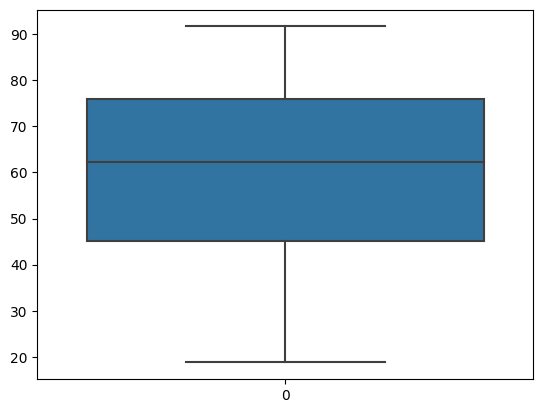

In [89]:
import seaborn as sns
sns.boxplot(df2['Temperature'])

In [90]:
# Correlation matrix
corr_matrix = df2.corr().round(2)
import plotly.figure_factory as ff
fig = ff.create_annotated_heatmap(corr_matrix.values,
                                  x = corr_matrix.columns.tolist(),
                                  y = corr_matrix.index.tolist())
fig.show()
     

<ipython-input-90-c99238827a13>:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



# ***we do the same work above including new columns***

In [92]:
# Separate target variable Y from features X
print("Separating labels from features...")
target_variable = 'Weekly_Sales'
X = df2.drop(target_variable, axis = 1)
Y = df2.loc[:,target_variable]
print("...Done.")
print()
print('Y : ')
print(Y.head(2))
print()
print('X :')
print(X.head(2))

Separating labels from features...
...Done.

Y : 
0    1572117.54
1    1807545.43
Name: Weekly_Sales, dtype: float64

X :
   Store  Holiday_Flag  Temperature  Fuel_Price         CPI  Unemployment  \
0    6.0           NaN        59.61       3.045  214.777523         6.858   
1   13.0           0.0        42.38       3.435  128.616064         7.470   

  year month   day  
0   18    02  2011  
1   25    03  2011  


In [103]:
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=43)
print("...Done.")
print()   

Dividing into train and test sets...
...Done.



In [93]:
# Create pipeline for numeric features
numeric_features = ["Fuel_Price","Unemployment","Temperature","CPI"] # Names of numeric columns in X_train/X_test
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median',missing_values=np.nan)), # missing values will be replaced by columns' median
    ('scaler', StandardScaler())
])

## ***Distribution of each numeric variable***

In [94]:
# analysis
for i in range(len(numeric_features)):
    fig = px.histogram(df2[numeric_features[i]])
    fig.show()

In [95]:
from sklearn.preprocessing import OrdinalEncoder

# Encode categorical features as an integer array.

# The input to this transformer should be an array-like of integers or strings,
#  denoting the values taken on by categorical (discrete) features. The features are converted
#   to ordinal integers. This results in a single column of integers (0 to n_categories - 1) per feature.

# Create pipeline for categorical features
categorical_features = ['Store', 'Holiday_Flag','year', 'month', 'day'] # Names of categorical columns in X_train/X_test
categorical_transformer = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  
    ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
    ]) 

## ***Barplot of each qualitative variable***

In [96]:
# analysis
for i in range(len(categorical_features)):
    fig = px.bar(df2[categorical_features[i]])
    fig.show()

In [99]:
# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [104]:
# Preprocessings on train set
print("Performing preprocessings on train set...")
X_train = preprocessor.fit_transform(X_train)
print('...Done.')


Performing preprocessings on train set...
...Done.


In [105]:
# Preprocessings on test set
print("Performing preprocessings on test set...")
X_test = preprocessor.transform(X_test) # Don't fit again !! The test set is used for validating decisions

Performing preprocessings on test set...


Train model1

In [106]:
# Train model
print("Train model...")
model1 = LinearRegression()
model1.fit(X_train, Y_train)
print("...Done.")

Train model...
...Done.


In [107]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = model1.predict(X_train)
print("...Done.")
print(Y_train_pred[0:5])
print()

Predictions on training set...
...Done.
[1624385.19955438 1694138.73068311 1368202.60988513  427800.24918976
 1023093.73577486]



In [108]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = model1.predict(X_test)
print("...Done.")
print(Y_test_pred[0:5])
print()

Predictions on test set...
...Done.
[1935209.00019403 1793661.94595006  372330.01810143 1968284.40804473
 1482044.65616835]



R² scores

In [109]:
# Print R^2 scores
print("R2 score on training set : ", r2_score(Y_train, Y_train_pred))
print("R2 score on test set : ", r2_score(Y_test, Y_test_pred))

R2 score on training set :  0.9951746984003025
R2 score on test set :  0.936257323489887


In [110]:
print("Constant is: ", model1.intercept_)
print("coefficients are: ", model1.coef_) 

Constant is:  1240965.1096938564
coefficients are:  [  -43054.42150152   -81699.53784914    11974.19691442    49427.43242401
   339986.81085955 -1169341.29283684   450579.39554771 -1274659.89973828
   -77331.81101216  -883643.80939876  -679943.55945569 -1193585.12350137
   402604.49750325    18004.69404741  -104629.20252506   512111.5434965
   614908.2851915   -835395.34583942 -1095119.65213249  -587248.71940488
  -246999.04769673    46172.52083774   427650.49513297    38366.41138906
   259179.09523941   177449.35922477   -26855.9033854    203313.77450886
   124512.77393588    70102.37883245   285736.17180819   278504.84615387
   -75425.40014512   -20142.2254833     52679.1323901    101365.29715541
   -47613.90118387   124178.48370617   111763.19936109  -101270.24964309
    55907.56374439    76891.33366958    36608.49966296   -91991.08972588
    42667.27423869   -19988.8634844      5413.89137849   104073.17253068
   -30048.04958663    48493.71358202   178155.00602594   151563.24411819


# ***get names from onehotencoder***

In [111]:
column_names = []
for name, pipeline, features_list in preprocessor.transformers_: # loop over pipelines
    if name == 'num': # if pipeline is for numeric variables
        features = features_list # just get the names of columns to which it has been applied
    else: # if pipeline is for categorical variables
     
        features = pipeline.named_steps['encoder'].get_feature_names_out(features_list) # get output columns names from OneHotEncoder
    column_names.extend(features) # concatenate features names
        
print("Names of columns corresponding to each coefficient: ", column_names)

Names of columns corresponding to each coefficient:  ['Fuel_Price', 'Unemployment', 'Temperature', 'CPI', 'Store_2.0', 'Store_3.0', 'Store_4.0', 'Store_5.0', 'Store_6.0', 'Store_7.0', 'Store_8.0', 'Store_9.0', 'Store_10.0', 'Store_11.0', 'Store_12.0', 'Store_13.0', 'Store_14.0', 'Store_15.0', 'Store_16.0', 'Store_17.0', 'Store_18.0', 'Store_19.0', 'Store_20.0', 'Holiday_Flag_1.0', 'year_02', 'year_03', 'year_04', 'year_05', 'year_06', 'year_07', 'year_08', 'year_09', 'year_10', 'year_11', 'year_12', 'year_13', 'year_14', 'year_15', 'year_16', 'year_17', 'year_18', 'year_19', 'year_20', 'year_22', 'year_23', 'year_24', 'year_25', 'year_26', 'year_27', 'year_28', 'year_29', 'year_30', 'year_31', 'month_02', 'month_03', 'month_04', 'month_05', 'month_06', 'month_07', 'month_08', 'month_09', 'month_10', 'month_11', 'month_12', 'day_2011', 'day_2012']


In [112]:
# Create a pandas DataFrame
coefs = pd.DataFrame(index = column_names, data = model1.coef_.transpose(), columns=["coefficients"])
coefs.head()

,coefficients
Fuel_Price,-43054.421502
Unemployment,-81699.537849
Temperature,11974.196914
CPI,49427.432424
Store_2.0,339986.810860


In [113]:
# Compute abs() and sort values
feature_importance = abs(coefs).sort_values(by = 'coefficients')
feature_importance

,coefficients
year_25,5.413891e+03
Temperature,1.197420e+04
day_2011,1.317797e+04
Store_11.0,1.800469e+04
year_24,1.998886e+04
...,...
Store_7.0,8.836438e+05
Store_16.0,1.095120e+06
Store_3.0,1.169341e+06
Store_9.0,1.193585e+06


In [115]:
# Plot coefficients
fig = px.bar(feature_importance, orientation = 'h')
fig.update_layout(showlegend = False, 
                  margin = {'l': 120} # to avoid cropping of column names
                 )
fig.show()

# ***MAE MSE RMSE..***

In [116]:
mae = metrics.mean_absolute_error(Y_test, Y_test_pred)
mse = metrics.mean_squared_error(Y_test, Y_test_pred)
rmse = np.sqrt(mse) # or mse**(0.5)
r2 = metrics.r2_score(Y_test, Y_test_pred)
names=['MAE','MSE','RMSE','R²']
l=[mae,mse,rmse,r2]
tl=np.array(l).T.tolist()
s = pd.DataFrame(data = tl,index=names,columns = ['valeurs on test '])
s

,valeurs on test
MAE,1.068774e+05
MSE,2.400586e+10
RMSE,1.549382e+05
R²,9.362573e-01


# ***Ridge Lasso with grid search***

In [117]:
# Performing grid search with Ridge regularization
ridge1 = Ridge()
# Grid for best alphas
params = {'alpha': [0.0, 0.5 , 1 , 1.5, 2]}
gridsearch_ridge = GridSearchCV(ridge1, param_grid = params, cv = 5)
gridsearch_ridge.fit(X_train, Y_train)

# Getting best hyperparameter for best R² score
print("Best hyperparameters : ", gridsearch_ridge.best_params_)
print("Best R² score : ", gridsearch_ridge.best_score_)

Best hyperparameters :  {'alpha': 0.0}
Best R² score :  0.9017782425356264


# ***Lasso  time***

In [118]:
# Performing grid search with Lasso regularization
lasso1 = Lasso()
# Grid of values to be tested
params = {'alpha': [15, 25, 35, 45, 55, 65, 75]}
gridsearch_lasso = GridSearchCV(lasso1, param_grid = params, cv = 5)
gridsearch_lasso.fit(X_train, Y_train)

print("Best hyperparameters : ", gridsearch_lasso.best_params_)
print("Best R² score : ", gridsearch_lasso.best_score_)

Best hyperparameters :  {'alpha': 75}
Best R² score :  0.9200910162069784


# ***XGBRegressor***

In [130]:
from xgboost import XGBRegressor
# Create the model XGBRegressor
xgbboost = XGBRegressor(random_state=42, n_jobs=-1)

# Fit the model
xgbboost.fit(X_train,Y_train)

print("xgb boost/ R2 score on training set : ", xgbboost.score(X_train, Y_train))
print("xgb BOOSt/ R2 score on test set : ", xgbboost.score(X_test, Y_test))

xgb boost/ R2 score on training set :  0.999999843296017
xgb BOOSt/ R2 score on test set :  0.9315033524323816


# ***Random forest regressor***

In [132]:
print("Random Forest with default hyperparameters...")
regressor = RandomForestRegressor() # we must use a regressor here!
regressor.fit(X_train, Y_train)
print("...Done.")
print("R2 score on training set : ",regressor.score(X_train,Y_train))
print("R2 score on training set : ",regressor.score(X_test,Y_test))

Random Forest with default hyperparameters...
...Done.
R2 score on training set :  0.9580787208368555
R2 score on training set :  0.8495833044957504


In [133]:
# Perform grid search
print("Grid search...")
regressor = RandomForestRegressor()

# Grid of values to be tested
params = {
    'max_depth': [10, 12, 14],
    'min_samples_split': [4, 8],
    'n_estimators': [60, 80, 100]
}
gridrforest = GridSearchCV(regressor, param_grid = params, cv = 10, verbose = 2)
gridrforest.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridrforest.best_params_)
print("Best validation accuracy : ", gridrforest.best_score_)

Grid search...
Fitting 10 folds for each of 18 candidates, totalling 180 fits
[CV] END .max_depth=10, min_samples_split=4, n_estimators=60; total time=   0.1s
[CV] END .max_depth=10, min_samples_split=4, n_estimators=60; total time=   0.1s
[CV] END .max_depth=10, min_samples_split=4, n_estimators=60; total time=   0.1s
[CV] END .max_depth=10, min_samples_split=4, n_estimators=60; total time=   0.1s
[CV] END .max_depth=10, min_samples_split=4, n_estimators=60; total time=   0.1s
[CV] END .max_depth=10, min_samples_split=4, n_estimators=60; total time=   0.1s
[CV] END .max_depth=10, min_samples_split=4, n_estimators=60; total time=   0.1s
[CV] END .max_depth=10, min_samples_split=4, n_estimators=60; total time=   0.1s
[CV] END .max_depth=10, min_samples_split=4, n_estimators=60; total time=   0.1s
[CV] END .max_depth=10, min_samples_split=4, n_estimators=60; total time=   0.1s
[CV] END .max_depth=10, min_samples_split=4, n_estimators=80; total time=   0.2s
[CV] END .max_depth=10, min_sam

In [134]:
# Print R^2 scores
print("R2 score on training set : ", gridrforest.score(X_train, Y_train))
print("R2 score on test set : ", gridrforest.score(X_test, Y_test))

R2 score on training set :  0.9434979317269836
R2 score on test set :  0.8391241841982968


# ***CONCLUSION : based on our R² scores in test nd train we notice that, theres no big difference using the regularization ,its bcs we have 150 rows we need more data to perfome better ***